In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import os
import zipfile
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Ekstrak file ZIP
zip_path = '/content/dataset2.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'File berhasil diekstrak ke {extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')

File berhasil diekstrak ke /content/


In [ ]:
# Folder dataset
image_dir = '/content/dataset2'
segmented_dir = '/content/dataset2_segmented'
os.makedirs(segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

# Data augmentation settings
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    return pred_mask[:, :, 0]  # Mask biner

images = []
labels = []

In [ ]:
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(image_dir, filename)
        mask = segment_image(img_path)
        segmented_path = os.path.join(segmented_dir, filename)
        cv2.imwrite(segmented_path, mask * 255)

        # Load segmented image
        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        # Tambahkan gambar asli
        images.append(img_array.astype(np.float32))
        labels.append(label)

        # Augmentasi sebanyak 3 kali
        img_array_expanded = np.expand_dims(img_array, axis=0)
        augmented_images = data_gen.flow(img_array_expanded, batch_size=1)

        for _ in range(2):
            aug_img = next(augmented_images)[0]  # Ambil batch pertama
            images.append(aug_img.astype(np.float32))
            labels.append(label)

X = np.array(images)
y = np.array(labels)

print(f"Total gambar setelah augmentasi: {len(X)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Total gambar setelah augmentasi: 48


In [ ]:
# Model sederhana
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    X, y,
    epochs=300,
    batch_size=32,
    callbacks=[checkpoint]
)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 227989.8281 - mae: 424.4860
Epoch 1: loss improved from inf to 231948.20312, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 229309.2812 - mae: 426.1200
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 181710.1250 - mae: 355.8546
Epoch 2: loss improved from 231948.20312 to 163691.39062, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 175703.8750 - mae: 348.5015
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 55376.9922 - mae: 169.3547
Epoch 3: loss improved from 163691.39062 to 63176.48828, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 57976.8242 - mae: 176.9187
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 96818.7812 - mae: 279.7471 
Epoch 4: loss did not improve from 63176.48828
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 93721.4609 - mae: 273.6684
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 57457.9766 -

File berhasil diekstrak ke /content/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


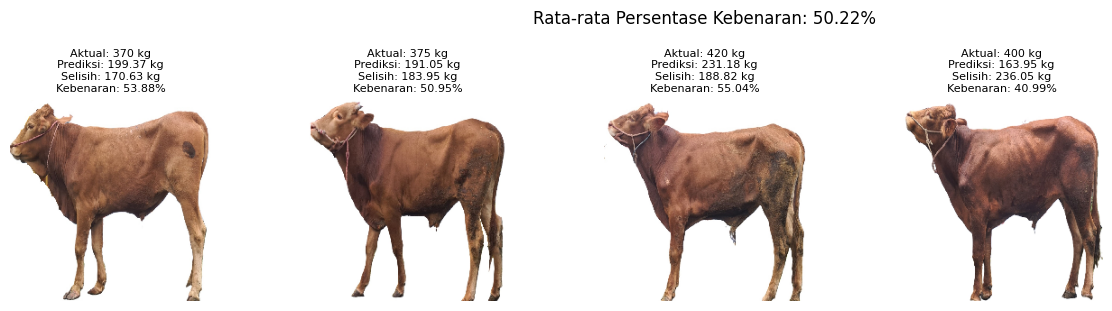

In [ ]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import math

test_zip_path = '/content/test.zip'
test_extract_path = '/content/'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print(f'File berhasil diekstrak ke {test_extract_path}')

image_dir = '/content/test'

images = []
labels = []

for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(image_dir, filename)
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0

        label = int(filename.split('.')[0])

        images.append(img_array)
        labels.append(label)

X = np.array(images)
y = np.array(labels)


best_model = tf.keras.models.load_model('best_model.keras')
prediksi_bobot = best_model.predict(X)
selisih = np.abs(y - prediksi_bobot.flatten())
persentase_kebenaran = 100 * (1 - selisih / y)
rata_rata_persentase = np.mean(persentase_kebenaran)


num_images = len(X)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f"Aktual: {y[i]} kg\nPrediksi: {prediksi_bobot[i][0]:.2f} kg\nSelisih: {selisih[i]:.2f} kg\nKebenaran: {persentase_kebenaran[i]:.2f}%", fontsize=8, color='black')

plt.suptitle(f"Rata-rata Persentase Kebenaran: {rata_rata_persentase:.2f}%", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

File berhasil diekstrak ke /content/


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


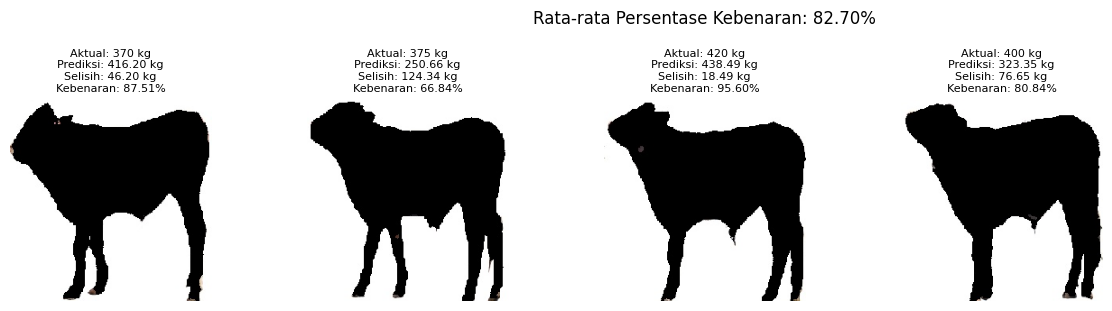

In [ ]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import math
import cv2

# Ekstrak file ZIP test
test_zip_path = '/content/test.zip'
test_extract_path = '/content/'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print(f'File berhasil diekstrak ke {test_extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')

# Folder dataset
test_image_dir = '/content/test'
test_segmented_dir = '/content/test_segmented'
os.makedirs(test_segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_WIDTH, SEGMENTATION_IMG_HEIGHT)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    segmented_image = image * np.expand_dims(pred_mask[:, :, 0], axis=-1)
    return segmented_image

images = []
labels = []

for filename in os.listdir(test_image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_image_dir, filename)
        segmented_image = segment_image(img_path)
        segmented_path = os.path.join(test_segmented_dir, filename)
        cv2.imwrite(segmented_path, cv2.cvtColor((segmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        images.append(img_array)
        labels.append(label)

X = np.array(images)
y = np.array(labels)

# Load model prediksi bobot sapi
best_model = tf.keras.models.load_model('best_model.keras')
prediksi_bobot = best_model.predict(X)
selisih = np.abs(y - prediksi_bobot.flatten())
persentase_kebenaran = 100 * (1 - selisih / y)
rata_rata_persentase = np.mean(persentase_kebenaran)

num_images = len(X)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f"Aktual: {y[i]} kg\nPrediksi: {prediksi_bobot[i][0]:.2f} kg\nSelisih: {selisih[i]:.2f} kg\nKebenaran: {persentase_kebenaran[i]:.2f}%", fontsize=8, color='black')

plt.suptitle(f"Rata-rata Persentase Kebenaran: {rata_rata_persentase:.2f}%", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()